In [ ]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import random
import cv2
import os
import imageio
from IPython.display import display
from google.colab.patches import cv2_imshow
from PIL import Image
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential           # Functional API 사용 예정.
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D            # Layers.
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
warnings.filterwarnings('ignore')                    # Turn the warnings off.
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# VGG16을 내려 받는다.
# 입력 크기는 224 이어야 한다.
my_vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
my_vgg.trainable = False                # 축가 학습은 불가능한 상태이다.

In [ ]:
# 더 좋은 결과를 위해서 내려받은 모델에서 MaxPooling2D층을 AveragePooling2D로 교체한다.
# MaxPooling2D나 AveragePooling2D는 학습 파라미터가 없는 층이므로 교체가 용이하다!
my_vgg_new = Sequential()
for a_layer in my_vgg.layers:
    if a_layer.__class__ == MaxPooling2D:
        my_vgg_new.add(AveragePooling2D())
    else:
        my_vgg_new.add(a_layer)

In [ ]:
# Layer 구조를 출력해 본다.
my_layers = []
for a_layer in my_vgg_new.layers:
    my_layers.append(a_layer.name)
print(my_layers)

['block1_conv1', 'block1_conv2', 'average_pooling2d', 'block2_conv1', 'block2_conv2', 'average_pooling2d_1', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'average_pooling2d_2', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'average_pooling2d_3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'average_pooling2d_4']


In [ ]:
# 가져온 모델의 summary (내부 구조) 출력.
#my_vgg_new.summary()

In [ ]:
# Content layer와 Style layers를 정의한다.
my_content_layer = ['block3_conv1']
my_style_layers = ['block1_conv1', 'block2_conv1','block3_conv1','block4_conv1','block5_conv1']

In [ ]:
# Functional API를 사용하여 모델을 만든다.
my_outputs = [ my_vgg_new.get_layer(a_layer).output for a_layer in my_content_layer + my_style_layers]
my_model = Model(inputs=[my_vgg_new.input], outputs=my_outputs )

In [ ]:
# 최종 모델의 summary (내부 구조) 출력.
#my_model.summary()

In [ ]:
# Style 이미지를 가져와서 resizing 해둔다.
img = Image.open(r"/content/drive/MyDrive/프로젝트 파일(최종본)/3차_VGG16_이미지합성/Test_folder/Picasso-The_Weeping_Woman.jpg")
#img = Image.open(r"../data/van_gogh.jpg")
X_raw = np.array(img)                          # Numpy 배열로 변환.
X_style = cv2.resize(X_raw,(224,224))        # BGR 또는 RGB channel 순서의 차이와 무관하게 리사이징이 가능하다.

In [ ]:
# Style 이미지의 행렬값 탐색.
print("MAX content value : {}".format(X_style.max()))
print("MIN content value : {}".format(X_style.min()))

MAX content value : 255
MIN content value : 0


array([[[175, 135,   6],
        [150, 113,   6],
        [132, 100,   6],
        ...,
        [200, 152,  13],
        [200, 153,  13],
        [201, 153,  12]],

       [[171, 130,   6],
        [141, 105,   3],
        [126,  95,   4],
        ...,
        [192, 149,  11],
        [192, 149,  10],
        [193, 150,  11]],

       [[168, 129,  10],
        [136, 102,   3],
        [124,  94,   7],
        ...,
        [193, 150,  11],
        [195, 151,  13],
        [194, 151,  12]],

       ...,

       [[ 27,  37,  45],
        [ 29,  39,  46],
        [ 29,  37,  50],
        ...,
        [ 37,  45,  56],
        [ 33,  43,  53],
        [ 28,  40,  50]],

       [[ 31,  38,  53],
        [ 39,  51,  40],
        [ 48,  61,  42],
        ...,
        [ 44,  53,  62],
        [ 33,  43,  53],
        [ 29,  37,  48]],

       [[ 29,  37,  48],
        [ 48,  58,  61],
        [ 43,  53,  53],
        ...,
        [ 35,  44,  53],
        [ 30,  40,  50],
        [ 29,  37,  48]]], dtype=uint8)
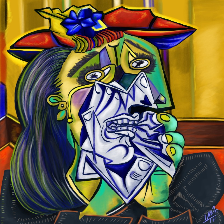

In [ ]:
X_style

# 이미지를 피클 파일로 저장하는 함수
def save_images_to_pickle_or(image_list, pickle_filename_or):
    with open(pickle_filename_or, 'wb') as f:
        pickle.dump(image_list, f)

# 피클 파일에서 이미지를 로드하는 함수
def load_images_from_pickle_or(pickle_filename_or):
    with open(pickle_filename_or, 'rb') as f:
        image_list = pickle.load(f)
    return image_list

In [ ]:
frame_folder = '/content/drive/MyDrive/프로젝트 파일(최종본)/3차_VGG16_이미지합성/Test_folder/frames'  # 프레임 폴더 경로 설정
frame_files = os.listdir(frame_folder)  # 프레임 폴더 내부 이미지 파일들 가져오기

In [ ]:
# X_original_0 ~ X_original_9 이미지 로드 및 처리
X_original_list = []
for i, file in enumerate(frame_files[:10]):
    # 이미지 파일 읽기
    img = Image.open(os.path.join(frame_folder, file))
    # 이미지를 NumPy 배열로 변환하고 0~1 사이의 값으로 스케일링
    X_raw = np.array(img) / 255.0
    # 이미지를 224x224 크기로 리사이징
    X_original = cv2.resize(X_raw, (224, 224))
    # X_original_0 ~ X_original_9에 추가
    X_original_list.append(X_original)

# 피클 파일의 경로 지정
pickle_filename_or = "/content/drive/MyDrive/프로젝트 파일(최종본)/3차_VGG16_이미지합성/Test_folder/X_original_list.pkl"

# 이미지를 피클 파일로 저장
save_images_to_pickle_or(X_original_list, pickle_filename_or)

# 이어지는 연산에 loaded_images를 사용한다

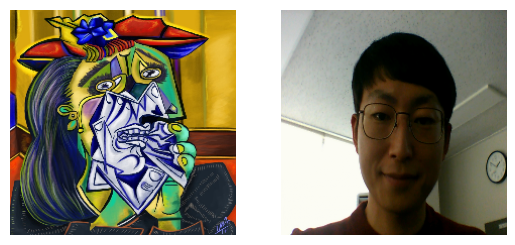

In [ ]:
# Style 이미지와 원본 이미지의 초기 상태 비교.
fig, axes = plt.subplots(1, 2)
axes[0].imshow(X_style)
axes[0].axis('off')
axes[1].imshow(X_original)
axes[1].axis('off')
plt.show()

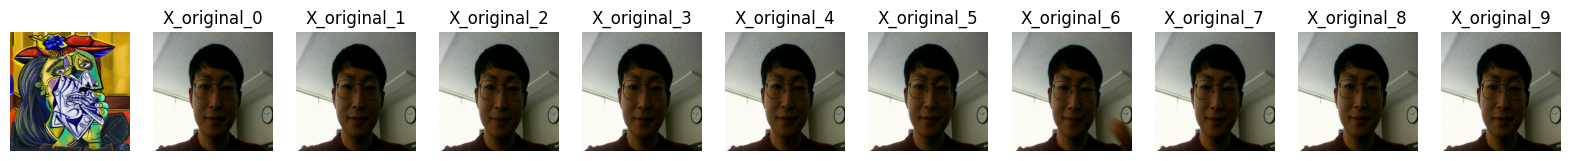

In [ ]:
# 저장된 이미지 피클 파일을 로드
#X_original_list = load_images_from_pickle_or(pickle_filename_or)

# X_original_0 ~ X_original_9 이미지 출력
fig, axes = plt.subplots(1, 11, figsize=(20, 5))
axes[0].imshow(X_style)
axes[0].axis('off')
for i in range(10):
    axes[i+1].imshow(X_original_list[i])
    axes[i+1].axis('off')
    axes[i+1].set_title(f'X_original_{i}')
plt.show()

#### 학습준비

In [ ]:
# Style 이미지의 출력은 딱 한번만 실행해 두면 된다!
my_outputs_style = my_model(preprocess_input(np.expand_dims(X_style,axis=0)))

In [ ]:
# X_original_list에서 처리한 10개의 이미지를 X_variables_list에 추가
X_variables_list = []
for X_original in X_original_list:
    # 이미지를 tf.Variable로 변환하여 X_variables_list에 추가
    X_variables_list.append(tf.Variable(X_original))

In [ ]:
#  출력의 shape를 보여준다.
for i in range(len(my_outputs_style)):
    print(my_outputs_style[i].shape)

(1, 56, 56, 256)
(1, 224, 224, 64)
(1, 112, 112, 128)
(1, 56, 56, 256)
(1, 28, 28, 512)
(1, 14, 14, 512)


In [ ]:
print("MAX array value : {:.3f}".format(X_original.max()))
print("MIN array value : {:.3f}".format(X_original.min()))

MAX array value : 1.000
MIN array value : 0.000


In [ ]:
# Gram 행렬을 계산해 주는 함수.
def gram(x):
    result = tf.linalg.einsum('bijc,bijd->bcd', x, x)             # b = batch이므로 그대로 둠. 사실상 c=d임. 동일한 크기 "HxWxC"의 행렬 (tensor)로 "CxC" Gram 행렬 계산!
    input_shape = x.shape
    denom = input_shape[1]*input_shape[2]                         # input_chape[1] = H, input_chape[2] = W. 그러므로 denom = HxW.
    return result/denom

In [ ]:
# 이미지 행렬의 값이 0~1을 벗어나면 clipping 해주는 함수.
def clip_0_1(x):
    return tf.clip_by_value(x, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
# VGG를 통과한 일종의 "예측값"을 계산해 주는 함수.
# 주의: preprocess_input 함수는 행렬의 원소가 0~255임을 전제한다.
#       그러므로 255를 곱해 주어야만 한다.
# Batch 학습을 하는 상황은 아니지만 batch에 해당하는 차원 (axis=0)을 확장시켜 주어야만 한다.
@tf.function
def predict():
    # 이미지를 전처리하고 연결
    preprocessed_images = preprocess_input(tf.concat([tf.expand_dims(img * 255, axis=0) for img in X_variables_list[:2]], axis=0))
    # 모델에 입력하여 예측 수행
    return my_model(preprocessed_images)


In [ ]:
cache ={}
@tf.function
def loss(y_pred, y):
    mse_content = tf.reduce_mean((y_pred[0] - y[0])**2)  # Content loss.

    if not "Gs" in cache:
        cache["Gs"] = [gram(y[i]) for i in range(1, 6)]  # Style 이미지의 Gram은 단 한번 계산해서 cache에 저장해 둔다.
    Gs = cache["Gs"]

    mse_style = 0
    for i in range(1, 6):
        if i == 1:
            mse_style += tf.reduce_mean((gram(y_pred[i]) - Gs[i-1])**2)  # 처음 계산.
        else:
            mse_style += tf.reduce_mean((gram(y_pred[i]) - Gs[i-1])**2)  # 누적.

    return mse_content + 0.001*mse_style


In [ ]:
# 하이퍼 파라미터를 설정해 준다.
n_epochs = 300                     # Number of epochs.
learn_rate = 0.005                  # learning rate.

In [ ]:
# 최적화 객체 생성.
my_optimizer = Adam(learning_rate=learn_rate)

def save_variables_to_pickle(variables_list, pickle_filename_var):
    with open(pickle_filename_var, 'wb') as f:
        pickle.dump(variables_list, f)

# 피클 파일의 경로 지정
pickle_filename_var = "/content/drive/MyDrive/프로젝트 파일(최종본)/3차_VGG16_이미지합성/Test_folder/X_variables_list.pkl"

# 연산 결과를 피클 파일로 저장
save_variables_to_pickle(X_variables_list, pickle_filename_var)

# 피클 파일에서 이미지를 로드하는 함수
def load_variables_from_pickle(pickle_filename_var):
    with open(pickle_filename_var, 'rb') as f:
        variables_list = pickle.load(f)
    return variables_list

# 피클 파일에서 이미지 로드
X_variables_list = load_variables_from_pickle(pickle_filename_var)

In [ ]:
my_loss_history = []  # 손실을 기록해 주는 list.

# 3번의 반복
for i_epoch in range(n_epochs):
    with tf.GradientTape() as tape:
        # 이미지를 모델에 입력하여 예측 수행
        my_outputs = predict()

        # 손실 계산.
        my_loss = loss(my_outputs, my_outputs_style)

        # 손실을 기록
        if (i_epoch % 10 == 0):
            my_loss_history.append(my_loss.numpy())
# 20=19   21=20사진
    # 그래디언트 계산.
    gradients = tape.gradient(my_loss, X_variables_list[:2])

    # 그래디언트 적용.
    my_optimizer.apply_gradients(zip(gradients, X_variables_list[:2]))

    # Clipping 해준다.
    for i, var in enumerate(X_variables_list[:2]):
        X_variables_list[i].assign(clip_0_1(var))


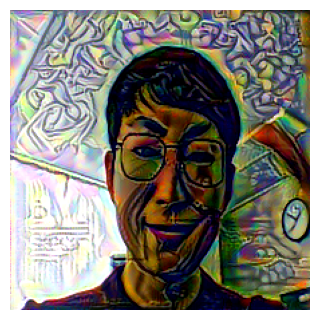

In [ ]:
# Style 전이가 된 이미지만을 조금 더 크게 출력해 본다.
fig = plt.figure(figsize=(3,3))
axes = fig.add_axes([0,0,1,1])
axes.imshow(X_variables_list[0].numpy())
axes.axis('off')
plt.show()

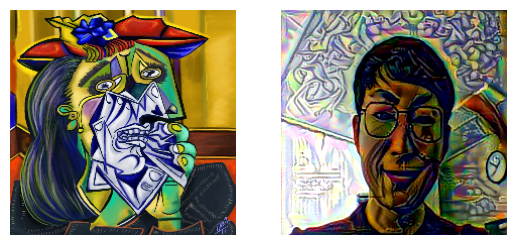

In [ ]:

# Style 이미지와 합성 이미지 비교.
fig, axes = plt.subplots(1, 2)
axes[0].imshow(X_style)
axes[0].axis('off')
axes[1].imshow(X_variables_list[40].numpy())
axes[1].axis('off')
plt.show()

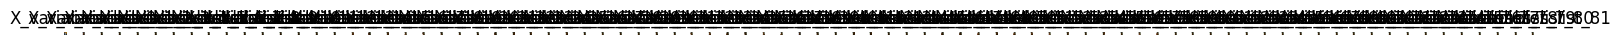

In [ ]:
# X_variables_list 출력
fig, axes = plt.subplots(1, len(X_variables_list) + 1, figsize=(15, 5))
axes[0].imshow(X_style)
axes[0].axis('off')

for i in range(len(X_variables_list)):
    axes[i+1].imshow(X_variables_list[i].numpy())
    axes[i+1].axis('off')
    axes[i+1].set_title(f'X_variables_list_{i}')
plt.tight_layout()
plt.show()

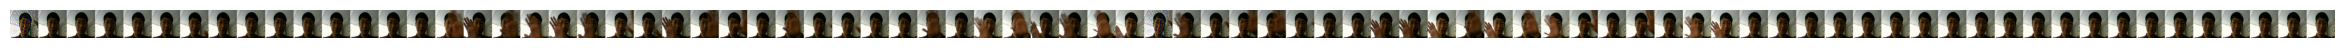

In [ ]:
# 전이 처리된 이미지를 가로로 결합
combined_image = tf.concat(X_variables_list, axis=1)

# 이미지 표시
plt.figure(figsize=(30, 5))
plt.imshow(combined_image.numpy())
plt.axis('off')
plt.show()

# 이미지 저장 경로 설정
save_path = "/content/drive/MyDrive/프로젝트 파일(최종본)/3차_VGG16_이미지합성/Test_folder/transferred_images/"

# 전이 처리된 이미지를 따로따로 저장
for i, image in enumerate(X_variables_list[:]):
    # 이미지 경로 설정
    image_path = save_path + f"합성 이미지_{i}.png"

    # 이미지를 uint8 타입으로 변환 후 저장
    image_uint8 = tf.cast(image * 255.0, tf.uint8)
    tf.keras.preprocessing.image.save_img(image_path, image_uint8)

    print(f"합성이미지 {i} 저장 완료 : {image_path}")

#### gif 파일로 전환

In [ ]:
# PNG 파일이 있는 디렉토리 경로
png_folder = "/content/drive/MyDrive/프로젝트 파일(최종본)/3차_VGG16_이미지합성/Test_folder/transferred_images"

# GIF 파일의 경로와 이름
gif_filename = "/content/drive/MyDrive/프로젝트 파일(최종본)/3차_VGG16_이미지합성/Test_folder/Jay-won.gif"

# PNG 파일 목록 가져오기
png_files = [os.path.join(png_folder, file) for file in os.listdir(png_folder) if file.endswith('.png')]

# 프레임 파일들을 읽어들여서 GIF로 저장
frames = []
for file in png_files:
    frame = imageio.imread(file)  # 프레임 파일을 읽어서 이미지 배열로 변환
    frames.append(frame)

# frames를 이용하여 GIF 파일 생성
imageio.mimsave(gif_filename, frames, duration=0.2)  # duration은 각 프레임 간의 시간 간격을 결정합니다.

In [ ]:
from IPython.display import Image

# GIF 파일을 출력
Image(filename=gif_filename)

Output hidden; open in https://colab.research.google.com to view.